<div style="background-color:#3c3d41;padding:30px;border-radius:5px">

<h1 style="font-size:22px;color:white;margin-top:0px">
How to read and plot FIREX-AQ MASTER L2 FRP with python ?
</h1>

<p style="font-size:14px;color:white">
Author: Benjamin Marchant<br>
License: CC BY 4.0
</p>
  
</div>

Python can be used to read and plot the FIREX-AQ MASTER L2 FRP. Here, we will walk through the steps necessary to do so. 

First, you will need to get the Python packages needed to work with your data. These packages include numpy, scipy, matplotlib, and netCDF4. Once you have these installed, you will be able to open the FIREX-AQ MASTER L2 FRP file in Python using the netCDF4 library. 

In [1]:
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree
from matplotlib.pyplot import figure
from pylab import matplotlib
from scipy.signal import convolve2d

import netCDF4
import numpy as np
import numpy.ma as ma
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sn
import math
import random
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()

warnings.filterwarnings('ignore')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Create a list of all MASTER L2 Files

Data can be found:

https://drive.google.com/drive/folders/1dA8SHlcQiA2jJiUF82s2of3I6SRpiZbW?usp=sharing

Please specify the path where the data is located

In [3]:
root = '/Volumes/HD2/Datasets/Research'

In [4]:
MASTERFRP_Files = glob.glob('{}/MASTERFRP/*.nc'.format(root))

print( len(MASTERFRP_Files) )

275


## Read and Plot data for a single granule

Let's consider the following file corresponding to the Williams Flats Fire

In [5]:
MASTERFRP_File = '/Volumes/HD2/Datasets/Research/MASTERFRP/MASTERFRP_1981715_15_20190730_0219_0231_V01.nc'

In [6]:
filename = MASTERFRP_File.split('/')[-1]

year = filename.split('_')[3][0:4]
month = filename.split('_')[3][4:6]
day = filename.split('_')[3][6:8]

hour = filename.split('_')[4][0:2]
minute = filename.split('_')[4][2:4]

print(year,month,day)
print(hour,minute)

2019 07 30
02 19


In [7]:
f = netCDF4.Dataset(MASTERFRP_File)

print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): n_profiles(314), n_bins(1388)
    variables(dimensions): float32 FRP(n_bins, n_profiles), int32 MASK(n_bins, n_profiles), float32 Longitude(n_bins, n_profiles), float32 Latitude(n_bins, n_profiles)
    groups: 


In [8]:
f.variables

{'FRP': <class 'netCDF4._netCDF4.Variable'>
 float32 FRP(n_bins, n_profiles)
     units: MW
     long_name: Fire Radiative Power
 unlimited dimensions: 
 current shape = (1388, 314)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'MASK': <class 'netCDF4._netCDF4.Variable'>
 int32 MASK(n_bins, n_profiles)
     units: none
     long_name: fire type mask: 0-no fire,1-smoldering, 2-flaming, 253-saturated, 254-unclassfied, 255-bad data
 unlimited dimensions: 
 current shape = (1388, 314)
 filling on, default _FillValue of -2147483647 used,
 'Longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 Longitude(n_bins, n_profiles)
     _FillValue: -999.0
     units: degree
 unlimited dimensions: 
 current shape = (1388, 314)
 filling on,
 'Latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 Latitude(n_bins, n_profiles)
     _FillValue: -999.0
     units: degree
 unlimited dimensions: 
 current shape = (1388, 314)
 filling on}

In [9]:
sds_shape = 0

df = pd.DataFrame()

for key,variable in f.variables.items():
    sds = f.variables[key]
    data = ma.getdata(sds)
    if sds_shape == 0:
        sds_shape = data.shape
    df[key] = data.ravel()

x_axis_size = data.shape[1]
y_axis_size = data.shape[0] 
  
xv, yv = np.meshgrid(np.arange(0,x_axis_size), np.arange(0,y_axis_size))
    
df['sample'] = xv.flatten() 
df['line'] = yv.flatten() 

    
df

,FRP,MASK,Longitude,Latitude,sample,line
0,0.0,0,-121.214928,41.868652,0,0
1,0.0,0,-121.214813,41.868549,1,0
2,0.0,0,-121.214699,41.868443,2,0
3,0.0,0,-121.214584,41.868332,3,0
4,0.0,0,-121.214470,41.868225,4,0
...,...,...,...,...,...,...
435827,0.0,0,-121.271240,41.782211,309,1387
435828,0.0,0,-121.271126,41.782104,310,1387
435829,0.0,0,-121.271004,41.781994,311,1387
435830,0.0,0,-121.270874,41.781868,312,1387


In [10]:
sds_shape

(1388, 314)

### FRP MASK counts

0-no fire,1-smoldering, 2-flaming, 253-saturated, 254-unclassfied, 255-bad data

In [11]:
df['MASK'].value_counts()

0      396209
1       21541
2       16945
255       641
253       496
Name: MASK, dtype: int64

### FRP histogram

<AxesSubplot:>

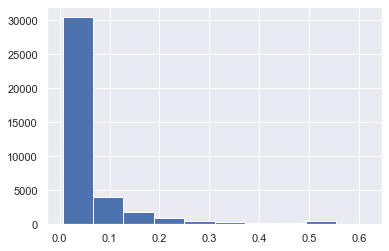

In [12]:
df['FRP'][ df['FRP'] > 0.0 ].hist()

### Calculate total FRP

In [13]:
df['FRP'][ df['FRP'] > 0.0 ].sum()

2243.2188

### Plot FRP

In [14]:
cmap = cm.get_cmap('hot', 100)    

color_list = ['#808080']

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    #print(matplotlib.colors.rgb2hex(rgba))
    color_list.append(matplotlib.colors.rgb2hex(rgba))

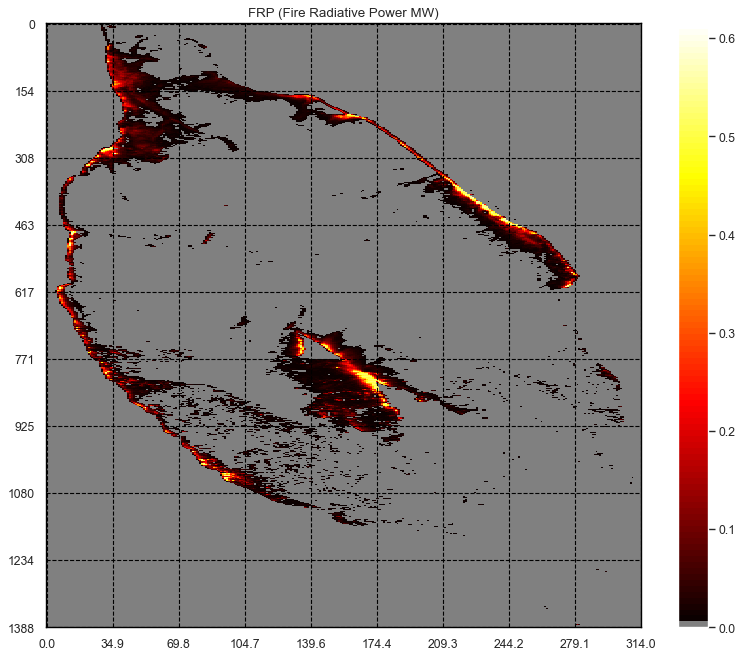

In [15]:
def plot_frp(data,filename,show_plot):

    cmap = cm.get_cmap('hot', 100)   

    color_list = ['#808080']

    for i in range(cmap.N):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba
        #print(matplotlib.colors.rgb2hex(rgba))
        color_list.append(matplotlib.colors.rgb2hex(rgba))
    
    fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

    ax = fig.add_subplot(111)

    cmap = color_list
    cmap = mpl.colors.ListedColormap(cmap)

    plt.imshow(data, cmap=cmap, interpolation='nearest',aspect='auto')
    #plt.imshow(data, cmap='hot_r', interpolation='nearest',aspect='auto')

    plt.title('FRP (Fire Radiative Power MW)')

    cbar = plt.colorbar()

    cbar.ax.set_ylabel('', rotation=270)

    plt.grid(c='black',ls='--')

    plt.xticks(np.linspace(0, data.shape[1], 10))
    plt.yticks(np.linspace(0, data.shape[0], 10))

    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')

    plt.savefig('./outputs/L2/FRP/{}_frp.png'.format(filename.split('.')[0]), dpi=100, bbox_inches='tight')
    
    if show_plot:
        plt.show()

    plt.close()
    
    return None

data = df['FRP'].to_numpy().reshape(sds_shape)

plot_frp(data,filename,show_plot=True)

In [16]:
### Plot FRP MASK

In [17]:
cmap = cm.get_cmap('hot', 5)    # PiYG

color_list = ['#808080']

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))
    color_list.append(matplotlib.colors.rgb2hex(rgba))

#0b0000
#b20000
#ff5a00
#ffff04
#ffffff


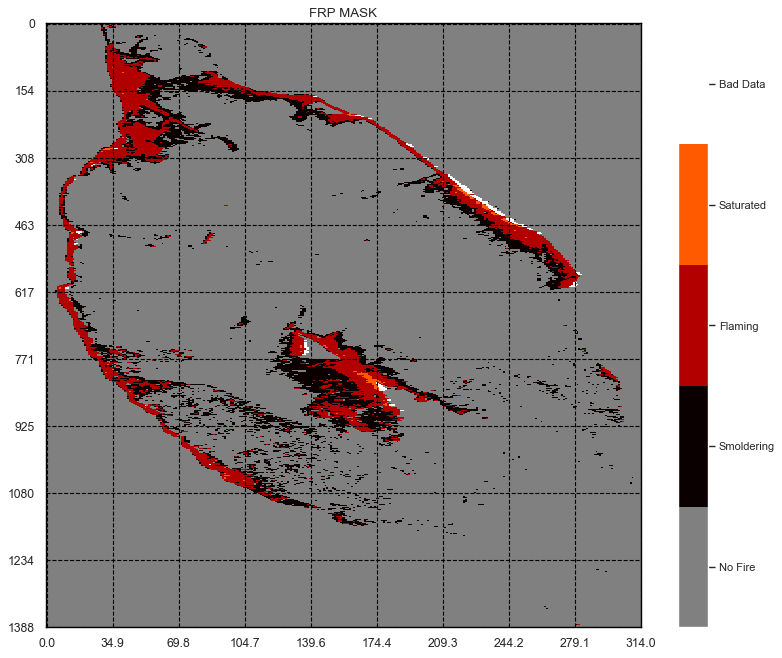

In [18]:
data = df['MASK'].to_numpy().reshape(sds_shape)

#0-no fire,1-smoldering, 2-flaming, 253-saturated, 254-unclassfied, 255-bad data

def plot_frp_mask(data,filename,show_plot):

    cmap = cm.get_cmap('hot', 5)    # PiYG

    color_list = ['#808080']

    for i in range(cmap.N):
        rgba = cmap(i)
        color_list.append(matplotlib.colors.rgb2hex(rgba))
    
    fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

    ax = fig.add_subplot(111)


    cmap =  [(0.0,0.0,0.0)] + [(32./255., 107./255., 164./255.)] + \
           [(187./255., 217./255., 238./255.)] + [(255./255, 51./255, 51./255.)] 
    cmap = mpl.colors.ListedColormap(cmap)


    cmap = color_list
    cmap = mpl.colors.ListedColormap(cmap)

    #cmap = cm.get_cmap('hot_r', 5)
    #cmap = cm.get_cmap('Dark2', 5)

    #cmap = mpl.colors.ListedColormap(cmap)

    bounds = [0, 0.5, 1.5, 252, 254, 255]

    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    img = plt.imshow(data, cmap=cmap, norm=norm, interpolation='none', aspect='auto')

    cbar_bounds = [0, 0.5, 1.5, 252, 254, 255]
    cbar_ticks =  [(cbar_bounds[i+1]-cbar_bounds[i])/2.0+cbar_bounds[i] for i in range( len(cbar_bounds) - 1 )] #  [0.5, 1.5, 155.0, 254.0, 255.0]  
    cbar_labels = ['No Fire', 'Smoldering','Flaming','Saturated', 'Bad Data']

    cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=cbar_bounds, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_labels, fontsize=10)

    plt.title('FRP MASK')

    plt.grid(c='black',ls='--')

    plt.xticks(np.linspace(0, data.shape[1], 10))
    plt.yticks(np.linspace(0, data.shape[0], 10))

    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')

    plt.savefig('./outputs/L2/FRP/{}_mask.png'.format(filename.split('.')[0]), dpi=100, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    
    plt.close()
    
    return None
    
plot_frp_mask(data,filename,show_plot=True)

### Plot Granule Longitudes and Latitudes

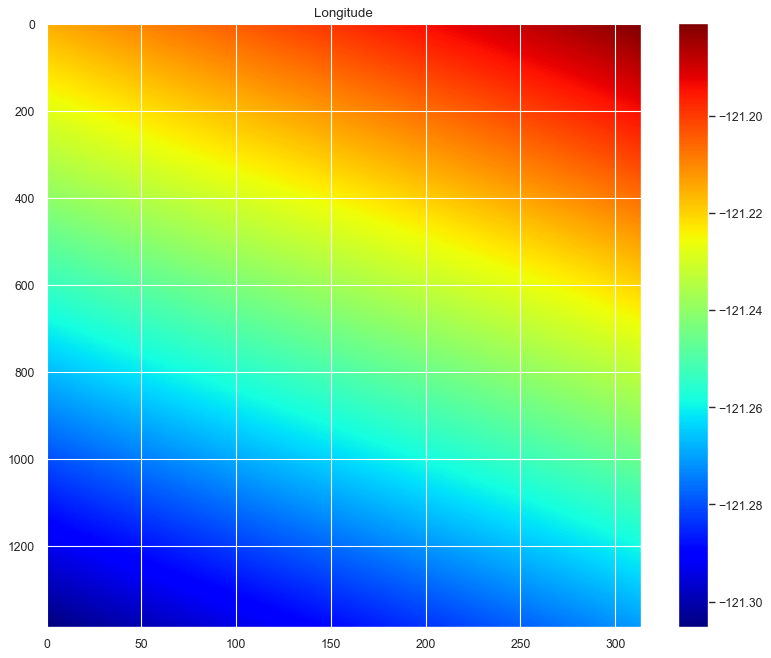

In [19]:
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

data = df['Longitude'].to_numpy().reshape(sds_shape)

plt.imshow(data, cmap='jet', interpolation='nearest',aspect='auto')

plt.title('Longitude')

plt.colorbar()

plt.show()

plt.close()

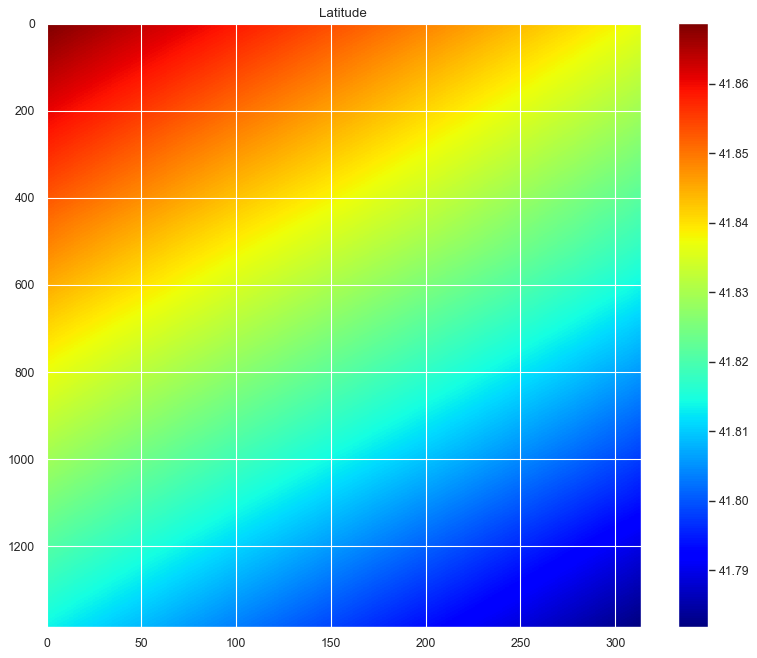

In [20]:
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

data = df['Latitude'].to_numpy().reshape(sds_shape)

plt.imshow(data, cmap='jet', interpolation='nearest',aspect='auto')

plt.title('Latitude')

plt.colorbar()

plt.show()

plt.close()

### FRP sum per MASK values

In [21]:
df_agg = df[['MASK','FRP']].groupby(by="MASK").sum()

df_agg = df_agg.reset_index()

df_agg

,MASK,FRP
0,0,0.000000
1,1,295.669037
2,2,1705.604248
3,253,241.945358
4,255,0.000000


### Data reggriding using a bilinear interpolation to put data on a (lat & long) regular grid.

In [22]:
min_long = df['Longitude'].min()
max_long = df['Longitude'].max()

min_lat = df['Latitude'].min()
max_lat = df['Latitude'].max()

print(min_long,max_long)
print(min_lat,max_lat)

-121.30534362792969 -121.18087768554688
41.781761169433594 41.86865234375


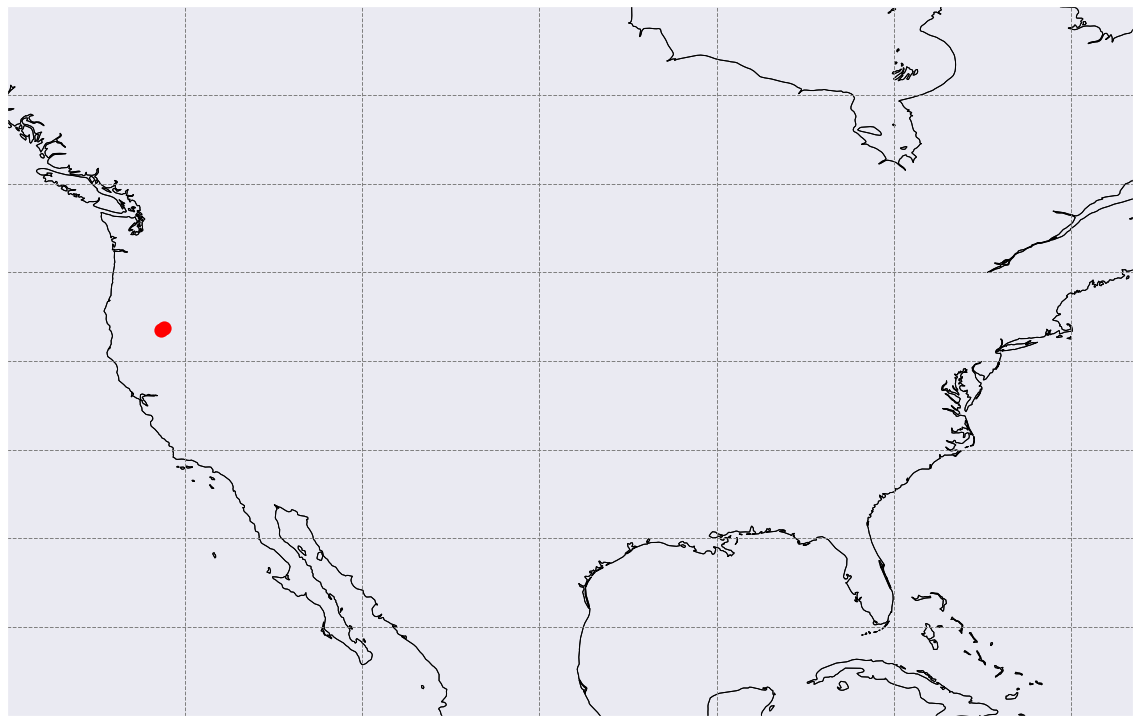

<function matplotlib.pyplot.close(fig=None)>

In [23]:
plt.figure(figsize=(16,12))

proj = ccrs.PlateCarree()

ease_extent = [-130, -66.5, 20, 60]
#ease_extent = [-121.51, -83.16, 30.79, 48.92]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 

ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

ax.coastlines(resolution='50m')

#lon_corners = np.array([-121.51,  -121.51, -83.16, -83.16])
#lat_corners = np.array([ 30.79, 48.92, 48.92, 30.79])

#poly_corners = np.zeros((len(lat_corners), 2), np.float64)
#poly_corners[:,0] = lon_corners
#poly_corners[:,1] = lat_corners

#poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=True, lw=1, fc=None, transform=ccrs.PlateCarree())
#ax.add_patch(poly)


plt.scatter( [min_long,max_long], [min_lat,max_lat],
         color='red', linewidth=2, marker='o', s=150,
         transform=ccrs.PlateCarree(),)

plt.tight_layout()

plt.show()

plt.close

In [24]:
cmap = cm.get_cmap('hot', 100)    # PiYG

color_list = ['#808080']

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    #print(matplotlib.colors.rgb2hex(rgba))
    color_list.append(matplotlib.colors.rgb2hex(rgba))

(1388, 314)
(1388, 314)
(1388, 314)


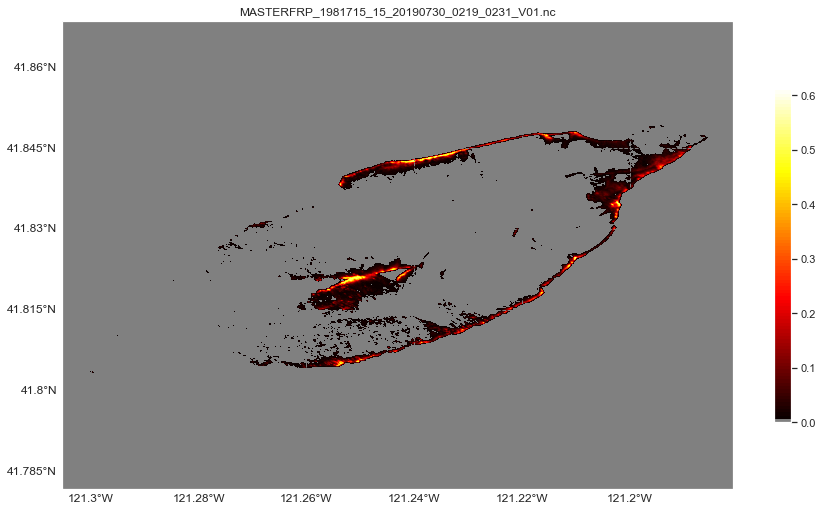

CPU times: user 29.1 s, sys: 206 ms, total: 29.3 s
Wall time: 29.8 s


In [25]:
%%time

proj = ccrs.PlateCarree()

lat_long_grid = proj.transform_points(                 
                    x = df['Longitude'].to_numpy().reshape(sds_shape),
                    y = df['Latitude'].to_numpy().reshape(sds_shape),
                    src_crs = proj)

x_igrid = lat_long_grid[:,:,0] ## long
y_igrid = lat_long_grid[:,:,1] ## lat

#print(x_igrid.shape)

#----------#

z_igrid_01 = np.zeros(sds_shape)
z_igrid_02 = np.zeros(sds_shape)
z_igrid_03 = np.zeros(sds_shape)

z_igrid_01[:,:] = df['FRP'].to_numpy().reshape(sds_shape)
z_igrid_02[:,:] = df['sample'].to_numpy().reshape(sds_shape)
z_igrid_03[:,:] = df['line'].to_numpy().reshape(sds_shape)

print(z_igrid_01.shape)
print(z_igrid_02.shape)
print(z_igrid_03.shape)

x1_igrid = x_igrid.ravel()
y1_igrid = y_igrid.ravel()

z_igrid_01 = z_igrid_01.ravel()
z_igrid_02 = z_igrid_02.ravel()
z_igrid_03 = z_igrid_03.ravel()


xy1_igrid = np.vstack((x1_igrid, y1_igrid)).T
#xi, yi = np.mgrid[min_long:max_long:1000j, min_lat:max_lat:1000j]
xi, yi = np.meshgrid( np.linspace(min_long, max_long, 1500) , np.linspace(min_lat, max_lat, 1000) )

z_01 = griddata(xy1_igrid, z_igrid_01, (xi, yi), method='nearest')
z_02 = griddata(xy1_igrid, z_igrid_02, (xi, yi), method='nearest')
z_03 = griddata(xy1_igrid, z_igrid_03, (xi, yi), method='nearest')

#----------#

THRESHOLD = 0.0001

tree = cKDTree(xy1_igrid)
arr_x = _ndim_coords_from_arrays((xi, yi))
dists, indexes = tree.query(arr_x)

z_01[dists > THRESHOLD] = np.nan
z_02[dists > THRESHOLD] = np.nan
z_03[dists > THRESHOLD] = np.nan

#----------#

whereAreNaNs = np.isnan(z_01);
z_01[whereAreNaNs] = 0.;

whereAreNaNs = np.isnan(z_02);
z_02[whereAreNaNs] = 0.;

whereAreNaNs = np.isnan(z_03);
z_03[whereAreNaNs] = 0.;

plt.figure(figsize=(12,12))

proj = ccrs.PlateCarree()

offset = 0.0

ease_extent = [min_long-offset, 
               max_long+offset, 
               min_lat-offset, 
               max_lat+offset]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 


swe_extent = [min_long, max_long, min_lat, max_lat]

cmap = color_list
cmap = mpl.colors.ListedColormap(cmap)

im = ax.imshow(np.rot90(np.fliplr(z_01)), extent=swe_extent, transform=proj, origin='lower', aspect=1., cmap=cmap)

cb = plt.colorbar(im, shrink=0.4)

g1 = ax.gridlines(draw_labels=True, color='gray', linestyle='--')

ax.coastlines()

#plt.title('FIREX-AQ MASTER \n Fire Radiative Power (MW) \n {}-{}-{} {}:{} \n FRP TOT {:.2f}MW'.format(year,month,day,hour,minute,FRP_tot),fontsize=14)

g1.top_labels = False
g1.right_labels = False

plt.tight_layout()

plt.title(filename)

#plt.savefig('./outputs/FIREX_AQ_MASTER_FRP_Regridding_{}{}{}_{}{}.png'.format(year,month,day,hour,minute), dpi=100, bbox_inches='tight')

plt.show()

plt.close()

In [26]:
df_gridded = pd.DataFrame()

df_gridded['FRP'] = z_01.ravel()
df_gridded['Sample'] = z_02.ravel()
df_gridded['Line'] = z_03.ravel()

df_gridded

,FRP,Sample,Line
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
1499995,0.0,0.0,0.0
1499996,0.0,0.0,0.0
1499997,0.0,0.0,0.0
1499998,0.0,0.0,0.0


In [27]:
df_gridded['FRP'][ df_gridded['FRP'] > 0.0 ].sum()

3353.236223944463

In [28]:
df_gridded_gr =  df_gridded.groupby(['Sample', 'Line']).max()

df_gridded_gr['FRP'][ df_gridded_gr['FRP'] > 0.0 ].sum()

2242.362523306161

In [29]:
z_01.sum()

3353.236223944463

In [30]:
df['FRP'][ df['FRP'] > 0.0 ].sum()

2243.2188

### Loop over all granules

In [31]:
for MASTERFRP_File in MASTERFRP_Files:
    
    filename = MASTERFRP_File.split('/')[-1]

    year = filename.split('_')[3][0:4]
    month = filename.split('_')[3][4:6]
    day = filename.split('_')[3][6:8]

    hour = filename.split('_')[4][0:2]
    minute = filename.split('_')[4][2:4]
    
    f = netCDF4.Dataset(MASTERFRP_File)

    sds_shape = 0

    df = pd.DataFrame()

    for key,variable in f.variables.items():
        sds = f.variables[key]
        data = ma.getdata(sds)
        if sds_shape == 0:
            sds_shape = data.shape
        df[key] = data.ravel()
 
    data = df['FRP'].to_numpy().reshape(sds_shape)
    
    plot_frp(data,filename,False)
    
    data = df['MASK'].to_numpy().reshape(sds_shape)
    
    plot_frp_mask(data,filename,False)
    
    f.close()

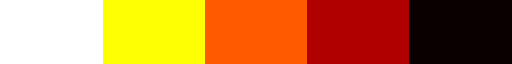

In [32]:
cm.get_cmap('hot_r', 5)

In [33]:
from pylab import matplotlib

cmap = cm.get_cmap('hot', 5)    # PiYG

color_list = ['#808080']

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))
    color_list.append(matplotlib.colors.rgb2hex(rgba))

#0b0000
#b20000
#ff5a00
#ffff04
#ffffff


## Master Downsampling

In [34]:
MASTER_TOT_FRP = []

for MASTERFRP_File in MASTERFRP_Files:
    
    filename = MASTERFRP_File.split('/')[-1]
    
    year = filename.split('_')[3][0:4]
    month = filename.split('_')[3][4:6]
    day = filename.split('_')[3][6:8]

    hour = filename.split('_')[4][0:2]
    minute = filename.split('_')[4][2:4]

    f = netCDF4.Dataset(MASTERFRP_File)

    sds_shape = 0

    df = pd.DataFrame()
    
    
    
    for key,variable in f.variables.items():
        sds = f.variables[key]
        data = ma.getdata(sds)
        
        #if data.shape[0] > 1000:
        #    data.shape[0] / 1000
        #    kernel = np.ones((6, 1))
        #    convolved = convolve2d(data, kernel, mode='valid')
        #    data = convolved[::6, ::1] 
        
        if sds_shape == 0:
            sds_shape = data.shape
        df[key] = data.ravel()

    x_axis_size = data.shape[1]
    y_axis_size = data.shape[0] 
    
    grid_size = max(data.shape[1],data.shape[0])
    
    xv, yv = np.meshgrid(np.arange(0,x_axis_size), np.arange(0,y_axis_size))
    
    df['sample'] = xv.flatten() 
    df['line'] = yv.flatten() 
        
    #print(df)
    
    #print(data.shape)
    
    print( df['FRP'][ df['FRP'] > 0.0 ].sum() )
    MASTER_TOT_FRP.append(df['FRP'][ df['FRP'] > 0.0 ].sum())
    #print( df['FRP'][ df['FRP'] > 0.0 ]  )
    
    TOT_FRP = df['FRP'][ df['FRP'] > 0.0 ].sum()
    
    min_long = df['Longitude'].min() #- 0.1
    max_long = df['Longitude'].max() #+ 0.1

    min_lat = df['Latitude'].min() #- 0.1
    max_lat = df['Latitude'].max() #+ 0.1

0.47088382
0.06465576
0.3756938
0.08486013
0.16804807
49.31124
106.69561
12.564174
1.3141829
127.64014
0.03559757
2144.9968
1972.3041
893.0539
210.40428
16.095146
99.33185
88.836975
2243.2188
161.06146
54.197872
1264.8789
1891.3809
0.03585866
0.04541266
0.03602722
0.17857629
0.663442
0.052060742
39.36226
8.462365
196.54858
194.77924
154.16006
0.05519997
564.72034
1328.8303
565.48035
0.22757494
375.15656
138.58209
0.0482464
188.94246
2191.162
896.1034
0.017167186
3383.2078
993.8557
1438.9114
186.78564
0.03698029
415.35806
767.1019
996.902
1481.434
294.41382
0.018280247
0.033626467
9265.268
12978.829
6355.126
2730.6934
3374.974
1615.5942
1416.4807
0.03657875
0.06793201
32.42047
37.021416
42.612885
498.40585
416.4069
7.3109746
6.1654425
376.5402
136.06221
37.95627
60.139206
724.44525
707.58545
52.54003
808.582
405.812
358.00363
75.03833
398.37448
101.573044
177.23672
67.42295
257.53375
232.0871
150.70395
77.25313
95.444824
65.45712
61.89087
55.036747
40.557632
50.40873
66.19656
990.6387
8

In [35]:
0.47088382

0.47088382

In [36]:
11119 / 1500

7.4126666666666665

In [37]:
1200 / 1000

1.2

In [38]:
import math
print(math.ceil(4.2))

5


In [54]:
%%time

for idx,MASTERFRP_File in enumerate( MASTERFRP_Files[:1] ):
    
    filename = MASTERFRP_File.split('/')[-1]
    
    year = filename.split('_')[3][0:4]
    month = filename.split('_')[3][4:6]
    day = filename.split('_')[3][6:8]

    hour = filename.split('_')[4][0:2]
    minute = filename.split('_')[4][2:4]

    f = netCDF4.Dataset(MASTERFRP_File)

    sds_shape = 0

    df = pd.DataFrame()

    for key,variable in f.variables.items():
        sds = f.variables[key]
        data = ma.getdata(sds)
        
        print(key)
        
        if data.shape[0] > 1200:   
            
            n = math.ceil( data.shape[0] / 1200 )
            #print('-->',n)
            kernel = np.ones((n, 1))
            convolved = convolve2d(data, kernel, mode='valid')
            
            if key == 'Longitude' or key == 'Latitude':
                data = convolved[::n, ::1] / n 
            else:
                data = convolved[::n, ::1] 
            print(data)
            print('--------')
            
        sds_shape = data.shape
        
        df[key] = data.ravel()

    x_axis_size = data.shape[1]
    y_axis_size = data.shape[0] 
    
    #grid_size = min(data.shape[0], 1000)
    
    xv, yv = np.meshgrid(np.arange(0,x_axis_size), np.arange(0,y_axis_size))
    
    df['sample'] = xv.flatten() 
    df['line'] = yv.flatten() 
    
    #print(df)
    
    print( sds_shape )
    print(  data.size )
    print( 1111 * 602 )

FRP
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
--------
MASK
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
--------
Longitude
[[-118.87098999 -118.87105942 -118.87114944 ... -118.9272995
  -118.92749557 -118.92769775]
 [-118.87124557 -118.87133484 -118.87142181 ... -118.92735062
  -118.92752075 -118.92774734]
 [-118.87158966 -118.87169952 -118.87180252 ... -118.92739334
  -118.92758026 -118.92778473]
 ...
 [-119.23000107 -119.23013916 -119.23027649 ... -119.29628677
  -119.29644089 -119.29658585]
 [-119.23035736 -119.23048859 -119.23062897 ... -119.29666519
  -119.29682083 -119.29697342]
 [-119.23071671 -119.23085022 -119.23098755 ... -119.29702759
  -119.29717712 -119.29732437]]
--------
Latitude
[[34.90941162 34.90937614 34.90933342 ... 34.88352852 34.88343315
  34

In [65]:
%%time

cmap = cm.get_cmap('hot', 100)    # PiYG

color_list = ['#808080']

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    #print(matplotlib.colors.rgb2hex(rgba))
    color_list.append(matplotlib.colors.rgb2hex(rgba))

for idx,MASTERFRP_File in enumerate( MASTERFRP_Files ):
    
    filename = MASTERFRP_File.split('/')[-1]
    
    year = filename.split('_')[3][0:4]
    month = filename.split('_')[3][4:6]
    day = filename.split('_')[3][6:8]

    hour = filename.split('_')[4][0:2]
    minute = filename.split('_')[4][2:4]

    f = netCDF4.Dataset(MASTERFRP_File)

    sds_shape = 0

    df = pd.DataFrame()

    for key,variable in f.variables.items():
        sds = f.variables[key]
        data = ma.getdata(sds)
        
        if data.shape[0] > 800:   
            
            n = math.ceil( data.shape[0] / 800 )
            #print('-->',n)
            kernel = np.ones((n, 1))
            convolved = convolve2d(data, kernel, mode='valid')
            
            if key == 'Longitude' or key == 'Latitude':
                data = convolved[::n, ::1] / n 
            else:
                data = convolved[::n, ::1] 
            
        sds_shape = data.shape
        
        df[key] = data.ravel()

    x_axis_size = data.shape[1]
    y_axis_size = data.shape[0] 
    
    #grid_size = min(data.shape[0], 1000)
    
    xv, yv = np.meshgrid(np.arange(0,x_axis_size), np.arange(0,y_axis_size))
    
    df['sample'] = xv.flatten() 
    df['line'] = yv.flatten() 
        
    #print(df)
    
    print(data.shape)
    
    #print( df['FRP'][ df['FRP'] > 0.0 ].sum() )
    
    
    
    
    
    min_long = df['Longitude'].min() #- 0.1
    max_long = df['Longitude'].max() #+ 0.1

    min_lat = df['Latitude'].min() #- 0.1
    max_lat = df['Latitude'].max() #+ 0.1

    proj = ccrs.PlateCarree()

    lat_long_grid = proj.transform_points(                 
                        x = df['Longitude'].to_numpy().reshape(sds_shape),
                        y = df['Latitude'].to_numpy().reshape(sds_shape),
                        src_crs = proj)

    x_igrid = lat_long_grid[:,:,0] ## long
    y_igrid = lat_long_grid[:,:,1] ## lat

    #print(x_igrid.shape)

    #----------#

    z_igrid_01 = np.zeros(sds_shape)
    z_igrid_02 = np.zeros(sds_shape)
    z_igrid_03 = np.zeros(sds_shape)
    z_igrid_04 = np.zeros(sds_shape)
    
    z_igrid_01[:,:] = df['FRP'].to_numpy().reshape(sds_shape)
    z_igrid_02[:,:] = df['MASK'].to_numpy().reshape(sds_shape)
    z_igrid_03[:,:] = df['sample'].to_numpy().reshape(sds_shape)
    z_igrid_04[:,:] = df['line'].to_numpy().reshape(sds_shape)
    
    #print(z_igrid_01.shape)
    #print(z_igrid_02.shape)
    #print(z_igrid_03.shape)
    #print(z_igrid_04.shape)
    
    x1_igrid = x_igrid.ravel()
    y1_igrid = y_igrid.ravel()

    z_igrid_01 = z_igrid_01.ravel()
    z_igrid_02 = z_igrid_02.ravel()
    z_igrid_03 = z_igrid_03.ravel()
    z_igrid_04 = z_igrid_04.ravel()

    xy1_igrid = np.vstack((x1_igrid, y1_igrid)).T
    xi, yi = np.mgrid[min_long:max_long:1000j, min_lat:max_lat:1000j]
    #xi, yi = np.meshgrid( np.linspace(min_long, max_long, grid_size) , np.linspace(min_lat, max_lat, grid_size)  )    
    
    #print(xi)
    #print(xi.shape)
    #print(yi.shape)
    #print(z_igrid_01.shape)
    #print(xy1_igrid.shape)
    
    z_01 = griddata(xy1_igrid, z_igrid_01, (xi, yi), method='nearest')
    z_02 = griddata(xy1_igrid, z_igrid_02, (xi, yi), method='nearest')
    z_03 = griddata(xy1_igrid, z_igrid_03, (xi, yi), method='nearest')
    z_04 = griddata(xy1_igrid, z_igrid_04, (xi, yi), method='nearest')
    
    #----------#

    #THRESHOLD = 0.2
    THRESHOLD = 0.0001

    tree = cKDTree(xy1_igrid)
    arr_x = _ndim_coords_from_arrays((xi, yi))
    dists, indexes = tree.query(arr_x)

    z_01[dists > THRESHOLD] = np.nan
    z_02[dists > THRESHOLD] = np.nan
    z_03[dists > THRESHOLD] = np.nan
    z_04[dists > THRESHOLD] = np.nan
    
    #----------#

    whereAreNaNs = np.isnan(z_01);
    z_01[whereAreNaNs] = 0.;

    whereAreNaNs = np.isnan(z_02);
    z_02[whereAreNaNs] = 0.;

    whereAreNaNs = np.isnan(z_03);
    z_03[whereAreNaNs] = 0.;
    
    whereAreNaNs = np.isnan(z_04);
    z_04[whereAreNaNs] = 0.;
    
    #-------------------------------------------------------------#
    
    df_regridded = pd.DataFrame()

    df_regridded['FRP'] = z_01.ravel()
    df_regridded['Fire_Mask'] = z_02.ravel()
    df_regridded['Sample'] = z_03.ravel()
    df_regridded['Line'] = z_04.ravel()
    
    TOT_FRP_01 = df['FRP'][ df['FRP'] > 0.0 ].sum()
    
    dfg_regridded = df_regridded.groupby(['FRP', 'Sample', 'Line']).max()
    dfg_regridded.reset_index(inplace=True)
    
    TOT_FRP_02 = dfg_regridded['FRP'][ dfg_regridded['FRP'] > 0.0 ].sum()
    
    print( MASTER_TOT_FRP[idx], TOT_FRP_01, TOT_FRP_02)
    
    output_FileName = '{}_reggridded.hdf5'.format(filename.split('.')[0]) 

    store = pd.HDFStore('./outputs/MASTER_Reggridded/{}'.format(output_FileName))

    store.put('reggrided', df_regridded)

    metadata = {'shape_0':data.shape[0], 
                'shape_1':data.shape[1],
                'min_long':min_long,
                'max_long':max_long,
                'min_lat':min_lat,
                'max_lat':max_lat,
                'TOT_FRP_01':MASTER_TOT_FRP[idx],
                'TOT_FRP_02':TOT_FRP_02}

    store.get_storer('reggrided').attrs.metadata = metadata

    store.close()    
    
    #----------#
    '''
    plt.figure(figsize=(12,12))

    proj = ccrs.PlateCarree()

    offset = 0.0

    ease_extent = [min_long-offset, 
                   max_long+offset, 
                   min_lat-offset, 
                   max_lat+offset]

    ax = plt.axes(projection=proj)

    ax.set_extent(ease_extent, crs=proj) 


    swe_extent = [min_long, max_long, min_lat, max_lat]

    cmap = color_list
    cmap = mpl.colors.ListedColormap(cmap)

    im = ax.imshow(np.rot90(np.fliplr(z_01)), extent=swe_extent, transform=proj, origin='lower', aspect=1., cmap=cmap)

    cb = plt.colorbar(im, shrink=0.4)

    g1 = ax.gridlines(draw_labels=True, color='gray', linestyle='--')

    ax.coastlines()

    #plt.title('FIREX-AQ MASTER \n Fire Radiative Power (MW) \n {}-{}-{} {}:{} \n FRP TOT {:.2f}MW'.format(year,month,day,hour,minute,FRP_tot),fontsize=14)

    g1.top_labels = False
    g1.right_labels = False

    plt.tight_layout()

    plt.title(filename)

    plt.savefig('./outputs/remapped/{}.png'.format(filename.split('.')[0]), dpi=100, bbox_inches='tight')

    #plt.show()

    plt.close()
    '''
    #--------------

    f.close()

(794, 602)
0.47088382 0.4708838437218219 0.07650479534640908
(759, 373)
0.06465576 0.023024524562060833 0.0
(758, 553)
0.3756938 0.2928199211601168 0.0
(517, 300)
0.08486013 0.08486012974753976 0.08486012974753976
(191, 291)
0.16804807 0.16804807 0.16804806841537356
(427, 514)
49.31124 49.31124363048002 49.31124363048002
(726, 299)
106.69561 106.69561142846942 106.69561142846942
(721, 258)
12.564174 12.564173431135714 12.564173431135714
(211, 300)
1.3141829 1.3141829 1.3141827819636092
(638, 326)
127.64014 127.64014 127.6401324630715
(300, 300)
0.03559757 0.03559757 0.035597570706158876
(569, 272)
2144.9968 2144.9968 2144.9968044797424
(530, 343)
1972.3041 1972.3041 1972.3040659958497
(689, 304)
893.0539 893.0539 893.0539229544811
(477, 354)
210.40428 210.40428 210.4042835868895
(634, 345)
16.095146 16.095146 16.095145497005433
(456, 297)
99.33185 99.33184631231416 99.31989580769732
(775, 300)
88.836975 88.836975 88.82931541430298
(694, 314)
2243.2188 2243.218668782618 2242.54611185053

44.887245 44.887245 44.8872448366601
(299, 312)
1.0645695 1.0645695 1.0621682762284763
(299, 544)
12.672246 12.672246 11.941276434601605
(300, 702)
3.5767686 3.5767686 3.499988849958754
(399, 520)
32.297268 32.297268 32.21770644103526
(300, 300)
2.5569365 2.5569365 2.5569366100244224
(710, 299)
0.11669194 0.11669193999841809 0.11669193999841809
(787, 300)
1.5491112 1.5491113791213138 0.2974567972269142
(299, 290)
42.18416 42.18416 42.18415558361448
(304, 716)
21.480244 21.480244 20.319650389210437
(300, 682)
9.335807 9.335807 9.098615749981036
(436, 299)
84.51921 84.51921 84.51922007463872
(444, 300)
96.88599 96.88599 96.8859872277826
(476, 428)
126.13329 126.13329 126.1332988209324
(562, 645)
115.936134 115.936134 115.65338121995228
(299, 544)
32.326153 32.326153 32.30251598736504
(299, 452)
31.946262 31.946262 31.942617948094266
(300, 300)
0.0017084994 0.0017084994 0.001708499388769269
(440, 405)
80.43747 80.43747 80.36489773661197
(300, 716)
40.845016 40.845016 40.822687888937594
(2

In [ ]:
--> 10
--> 10
--> 10
--> 10
(1111, 602)
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
File <timed exec>:116, in <module>

File ~/opt/anaconda3/envs/worklab/lib/python3.9/site-packages/scipy/interpolate/_ndgriddata.py:258, in griddata(points, values, xi, method, fill_value, rescale)
    256 elif method == 'nearest':
    257     ip = NearestNDInterpolator(points, values, rescale=rescale)
--> 258     return ip(xi)
    259 elif method == 'linear':
    260     ip = LinearNDInterpolator(points, values, fill_value=fill_value,
    261                               rescale=rescale)

File ~/opt/anaconda3/envs/worklab/lib/python3.9/site-packages/scipy/interpolate/_ndgriddata.py:111, in NearestNDInterpolator.__call__(self, *args)
    109 xi = self._scale_x(xi)
    110 dist, i = self.tree.query(xi)
--> 111 return self.values[i]

IndexError: index 668822 is out of bounds for axis 0 with size 668822


In [40]:
MASTER_Reggridded_Files = glob.glob('./outputs/MASTER_Reggridded/*.hdf5')

for f in MASTER_Reggridded_Files[:5]:
    print(f.split('/')[-1])

MASTERFRP_1981712_02_20190722_1950_1958_V01_reggridded.hdf5
MASTERFRP_1981712_03_20190722_1959_2009_V01_reggridded.hdf5
MASTERFRP_1981712_04_20190722_2010_2018_V01_reggridded.hdf5


In [41]:
with pd.HDFStore(MASTER_Reggridded_Files[4]) as store:
    data = store['reggrided']
    metadata = store.get_storer('reggrided').attrs.metadata

print(data)

print(metadata)

IndexError: list index out of range

In [ ]:
data['frp'].to_numpy()

In [ ]:
data = data['frp'].to_numpy()
data = data.reshape(1000,1000)

In [ ]:
plt.figure(figsize=(12,12))

proj = ccrs.PlateCarree()

offset = 0.0

ease_extent = [min_long-offset, 
               max_long+offset, 
               min_lat-offset, 
               max_lat+offset]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 


swe_extent = [min_long, max_long, min_lat, max_lat]

cmap = color_list
cmap = mpl.colors.ListedColormap(cmap)

im = ax.imshow(np.rot90(np.fliplr(data)), extent=swe_extent, transform=proj, origin='lower', aspect=1., cmap=cmap)

cb = plt.colorbar(im, shrink=0.4)

g1 = ax.gridlines(draw_labels=True, color='gray', linestyle='--')

ax.coastlines()

#plt.title('FIREX-AQ MASTER \n Fire Radiative Power (MW) \n {}-{}-{} {}:{} \n FRP TOT {:.2f}MW'.format(year,month,day,hour,minute,FRP_tot),fontsize=14)

g1.top_labels = False
g1.right_labels = False

plt.tight_layout()

plt.title(filename)

#plt.savefig('./outputs/remapped/{}.png'.format(filename.split('.')[0]), dpi=100, bbox_inches='tight')

plt.show()

plt.close()

In [ ]:
df_frp = pd.DataFrame()

for MASTERFRP_File in MASTERFRP_Files:
    
    filename = MASTERFRP_File.split('/')[-1]

    year = filename.split('_')[3][0:4]
    month = filename.split('_')[3][4:6]
    day = filename.split('_')[3][6:8]

    hour = filename.split('_')[4][0:2]
    minute = filename.split('_')[4][2:4]
    
    f = netCDF4.Dataset(MASTERFRP_File)

    sds_shape = 0

    df = pd.DataFrame()

    for key,variable in f.variables.items():
        sds = f.variables[key]
        data = ma.getdata(sds)
        if sds_shape == 0:
            sds_shape = data.shape
        df[key] = data.ravel()
    
    f.close()
    
    data = {}
    
    tot_frp = df['FRP'][ df['FRP'] > 0.0 ].sum()
    
    min_long = df['Longitude'].min()
    max_long = df['Longitude'].max()

    min_lat = df['Latitude'].min()
    max_lat = df['Latitude'].max()
    
    data['MASTER_FRP_FileName'] = [filename]
    
    data['Flight_Number'] = filename.split('_')[1]
    
    data['Flight_Track'] = filename.split('_')[2]

    data['Year'] = [year]
    data['Month'] = [month]
    data['Day'] = [day]
    
    data['Hour'] = [hour]
    data['Minute'] = [minute]
    
    data['min_long'] = [min_long]
    data['max_long'] = [max_long]
    data['min_lat'] = [min_lat]
    data['max_lat'] = [max_lat]
    
    data['tot_frp'] = [tot_frp]
    
    df_frp_nr = pd.DataFrame(data)
    
    df_frp = pd.concat([df_frp,df_frp_nr], ignore_index=True)

In [ ]:
df_frp

In [ ]:
df_frp.plot.scatter(x='Flight_Number',y='tot_frp', c='DarkBlue')

In [ ]:
df_frp[ (df_frp['Month']=='08') & (df_frp['Day']=='03')]

## References

- [Heat flux assumptions contribute to overestimation of wildfire smoke injection into the free troposphere](https://www.nature.com/articles/s43247-022-00563-x)